In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap

In [2]:
df=pd.read_csv(r"C:\Users\ankam\OneDrive\Desktop\Research\sensor_data.csv")
df.head()

,Sensor A,Sensor B,Temperature,Wind Speed,Humidity,Anomaly Score
0,10,20,30,3.0,60,23.30
1,12,25,32,4.0,55,24.10
2,15,18,28,2.0,65,23.50
3,8,22,31,3.5,58,23.15
4,9,30,35,5.0,50,27.50


In [3]:
df.isnull().sum()

Sensor A         0
Sensor B         0
Temperature      0
Wind Speed       0
Humidity         0
Anomaly Score    0
dtype: int64

In [4]:
x=df.drop(['Anomaly Score'],axis=1)
y=df['Anomaly Score']

In [9]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=.30,random_state=42)

In [11]:
from sklearn.ensemble import RandomForestRegressor
model=RandomForestRegressor()
model.fit(x,y)

RandomForestRegressor()

In [13]:
explainer=shap.TreeExplainer(model)
shap_values=explainer.shap_values(x)

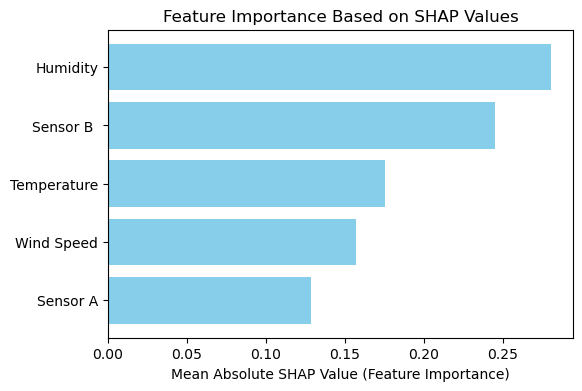

In [15]:
feature_importance = np.abs(shap_values).mean(axis=0)

# Create a DataFrame to hold feature names and importance values
feature_importance_df = pd.DataFrame({
    "Feature": x.columns,
    "Importance": feature_importance
})

# Sort by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False)

# Plot the feature importance bar plot
plt.figure(figsize=(6, 4))
plt.barh(feature_importance_df["Feature"], feature_importance_df["Importance"], color="skyblue")
plt.xlabel("Mean Absolute SHAP Value (Feature Importance)")
plt.title("Feature Importance Based on SHAP Values")
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top
plt.show()

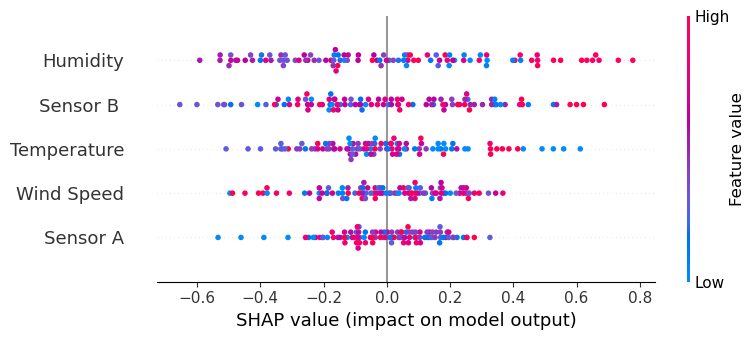

In [17]:
shap.summary_plot(shap_values, x)

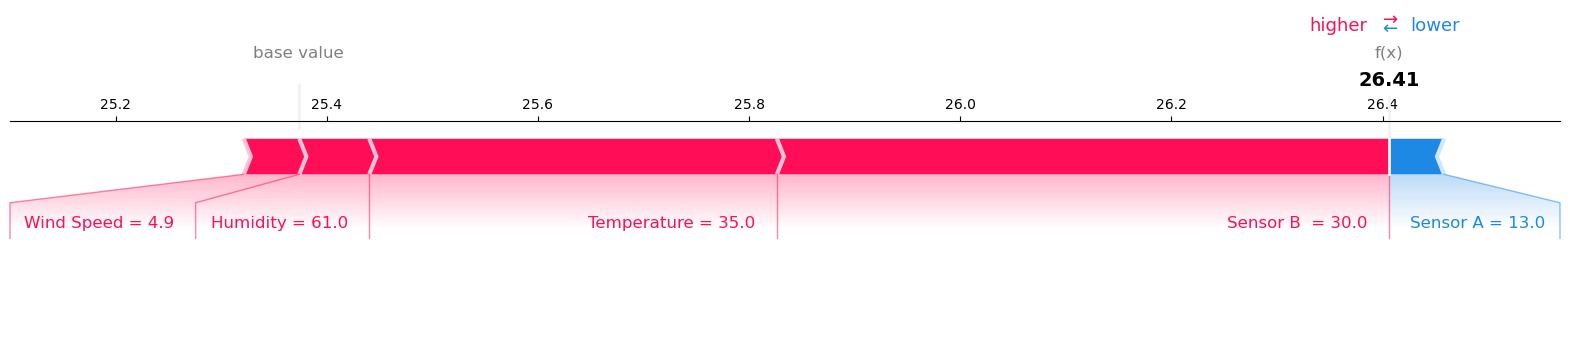

In [19]:
shap.force_plot(
        explainer.expected_value[0],  # Base value (expected value)
        shap_values[98],  # SHAP values for the selected instance
        x.iloc[98],  # Feature values for the selected instance
        matplotlib=True  # Use matplotlib for inline plots
    )
    # Display the plot
plt.show()

In [21]:
y_pred=model.predict(x_test)

In [23]:
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
mae=mean_absolute_error(y_test,y_pred)
mse=mean_squared_error(y_test,y_pred)
r2=r2_score(y_test,y_pred)
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R² Score: {r2:.4f}")

Mean Absolute Error (MAE): 0.4720
Mean Squared Error (MSE): 0.3025
R² Score: 0.8667


In [25]:
import joblib

# Save the model
joblib.dump(model, "toxicgas_rf_model.joblib")

['toxicgas_rf_model.joblib']

In [27]:
streamlit_code = """
import streamlit as st
import joblib
import numpy as np
import shap
import matplotlib.pyplot as plt

# Load the trained model
model = joblib.load("toxicgas_rf_model.joblib")

# Set up page style
st.set_page_config(page_title="Toxic Gas Leak Detection", layout="wide")
st.title("☣️ Toxic Gas Leak Detection & SHAP Analysis")

# Sidebar Input
st.sidebar.header("📊 Enter Sensor Readings")
sensor_a = st.sidebar.number_input("Sensor A (ppm)", min_value=0.0, format="%.2f")
sensor_b = st.sidebar.number_input("Sensor B (ppm)", min_value=0.0, format="%.2f")
temperature = st.sidebar.number_input("Temperature (°C)", min_value=-50.0, format="%.2f")
wind_speed = st.sidebar.number_input("Wind Speed (m/s)", min_value=0.0, format="%.2f")
humidity = st.sidebar.number_input("Humidity (%)", min_value=0.0, max_value=100.0, format="%.2f")

st.markdown("---")

# Prediction & SHAP Explanation
if st.sidebar.button("🚀 Predict Anomaly Score"):
    user_input = np.array([[sensor_a, sensor_b, temperature, wind_speed, humidity]])
    anomaly_score = model.predict(user_input)[0]

    # Display anomaly score
    st.success(f"### 🎯 Predicted Anomaly Score: *{anomaly_score:.4f}*")

    # Set anomaly detection threshold
    threshold = 25.0  # Adjust based on model behavior

    if anomaly_score > threshold:
        st.error("⚠ *Anomaly Detected!* This gas pattern suggests *a potential toxic leak.*")
        st.warning("☢️ Evacuate the area and check sensor readings immediately!")
    else:
        st.success("✅ *No Anomaly Detected!* The environment appears safe.")
        st.info("🌿 Sensor values are within the normal range.")

    # SHAP explanation
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(user_input)

    # SHAP Force Plot
    st.subheader("📊 SHAP Force Plot for Given Sensor Inputs")

    fig, ax = plt.subplots(figsize=(10, 3))
    force_plot = shap.force_plot(
        explainer.expected_value,
        shap_values[0],
        user_input[0],
        matplotlib=True,
        show=False
    )

    plt.savefig("force_plot.png", bbox_inches="tight", dpi=300)
    st.image("force_plot.png")

    # Analyze Force Plot colors (Red = abnormal, Blue = normal)
    if np.any(shap_values[0] > 0):  # If red areas exist (positive SHAP values)
        st.error("🔴 *High-risk gas activity detected!* Red zones indicate *strong contributors* to the anomaly.")
        st.warning("🚨 This may be due to high sensor readings or environmental changes.")

    elif np.any(shap_values[0] < 0):  # If blue areas exist (negative SHAP values)
        st.success("🔵 *Safe environmental conditions detected!* Blue zones indicate *factors reducing risk.*")

st.sidebar.success("✅ Adjust values and click 'Predict' to analyze gas leak risks.")
"""

# Save this code as a Python file
with open("toxic_gas_shap_app.py", "w", encoding="utf-8") as file:
    file.write(streamlit_code)

print(" Streamlit app saved as 'toxic_gas_shap_app.py'")


 Streamlit app saved as 'toxic_gas_shap_app.py'


In [ ]:
!streamlit run toxic_gas_shap_app.py